# HA Fiscal meets HANK and SAM

By William Du (wdu9@jhu.edu)

#### This notebook solves a HANK and SAM model where the household block follows the HA-Fiscal households closely.

#### This notebook will solve and illustrate the impulse responses to a:

 #### - UI extension
 #### - Increase in the replacement rate of UI
 #### - A cut to the tax rate
####  - An increase in transfers (that are proportional to your permanent income)
#### - A increase in government spending




In [1]:
# import necessary libraries
import numpy as np
from copy import deepcopy
import scipy.sparse as sp
import matplotlib.pyplot as plt
import time

# Calibrate job transition probabilities

In [2]:
# 6 markov states because we allow for up to 4 periods of unemployment benefits

job_find = 2/3 # job finding probability
EU_prob = 0.0306834 # EU probability
job_sep = EU_prob/ (1- job_find) # job separation rate


markov_array_ss = np.array([[ 1 - job_sep*(1 - job_find ), job_find, job_find, job_find , job_find , job_find],
       [job_sep*(1-job_find) , 0.        , 0.        , 0 ,  0, 0       ],
       [0.        , (1-job_find), 0.        , 0.  , 0.        , 0.       ],
       [0.        , 0, (1-job_find)        , 0.  , 0.        , 0.       ],
       [0.        , 0, 0.        , (1-job_find)  , 0.        , 0.       ],

       [0.        , 0. , 0 , 0       , (1-job_find), (1-job_find)]  ])

mrkv_temp_for_will =markov_array_ss

num_mrkv = len(markov_array_ss)

eigen, ss_dstn = sp.linalg.eigs(mrkv_temp_for_will , k=1, which='LM') # get steady state distribution over (un)employment states


ss_dstn = ss_dstn[:,0] / np.sum(ss_dstn[:,0]) # Steady state distribution of employed/unemployed 

ss_dstn = ss_dstn.real

U_ss = (1-ss_dstn[0]) # steady state unemployment

N_ss = ss_dstn[0] # steady state employment



# Compute Unemployment Rate Jacobian
$$N_{t} = (1-\omega) N_{t-1} + m_{t}$$, where $m_{t}=$matches and $\omega$ is the job separation rate


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


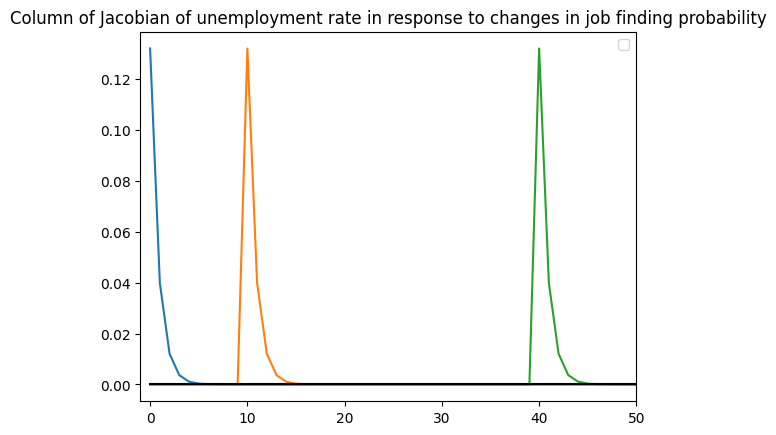

In [3]:
# jacobians for the mass of each markov state of employment.
# job finding rate is endogenous in the model, so we need this jacobian.
# for technical reasons this is better than using the equation N_{t} = (1-job_sep) N_{t-1} + m_{t}

def create_matrix_U(dx):
    
    job_find_dx = job_find + dx

    markov_array = np.array([[ 1 - job_sep*(1 - job_find_dx ), job_find_dx, job_find_dx, job_find_dx , job_find_dx , job_find_dx],
           [job_sep*(1-job_find_dx) , 0.        , 0.        , 0 ,  0, 0       ],
           [0.        , (1-job_find_dx), 0.        , 0.  , 0.        , 0.       ],
           [0.        , 0, (1-job_find_dx)        , 0.  , 0.        , 0.       ],
           [0.        , 0, 0.        , (1-job_find_dx)  , 0.        , 0.       ],

           [0.        , 0. , 0 , 0       , (1-job_find_dx), (1-job_find_dx)]  ])


    return markov_array

dx = 0.0001


dstn = ss_dstn

bigT = 300
UJAC = np.zeros((num_mrkv,bigT,bigT))

for s in range(bigT):
    for i in range(bigT):
        if i ==s:
            
            tranmat = create_matrix_U(dx)
        
            dstn = np.dot(tranmat,dstn)
    
        else:
            dstn = np.dot(mrkv_temp_for_will,dstn)
    
        UJAC[:,i,s] = (dstn - ss_dstn) / dx

plt.plot(UJAC[0].T[0])
plt.plot(UJAC[0].T[10])
plt.plot(UJAC[0].T[40])
plt.plot(np.zeros(bigT),color ='k')
#plt.legend()
plt.xlim(-1,50)
plt.title('Column of Jacobian of employment rate in response to changes in job finding probability')
plt.show()

# Calibration for General equilibrium parameters

In [4]:
# Calibrating General Equilibrium parameters

# elasticity
alpha = .65

# vacancy filling probability
phi_ss = .71 

#vacancies
v_ss = N_ss*job_sep / phi_ss


unemployed_searchers = (ss_dstn[1] + ss_dstn[2] + ss_dstn[3]+ ss_dstn[4]+ ss_dstn[5]) 

# typical job searcher mass is below,
seachers = unemployed_searchers + N_ss*job_sep

# labor market tightness
theta_ss = v_ss/seachers

# matching efficiency
chi_ss = (phi_ss**(1/-alpha) /theta_ss)**(-alpha)

# job finding probabilty economy wide
eta_ss  = chi_ss * theta_ss**(1-alpha) 


R = 1.01 # real interest rate
r_ss = R - 1

C_ss_sim  =0.6910496136078721
C_ss = C_ss_sim

A_ss_sim = 1.4324029855872642
A_ss = A_ss_sim


delta = ((R**4)*(1-(1/5)) )**(1/4) # or you can do delta = R*(1 -(1/20)), 20 quarters is 5 years

qb_ss = (1) / (R - delta) # real price of bonds


B_ss = A_ss/qb_ss # steady state level of bonds

wage_ss = 1.0 # steady state wage (normalized to one)


#before_tax_mean_income = np.mean(IncShkDstn_emp.atoms[1]) / (1-tau_ss)


inc_ui_exhaust = 0.5

tau_ss = 0.3 # steady state tax rate
UI = (1-tau_ss)*.5*wage_ss # Unemployment insurance

# private/passive spousal income
Y_priv = inc_ui_exhaust*(1-tau_ss)*wage_ss*( ss_dstn[3] + ss_dstn[4]  +  ss_dstn[5]  ) + (.7-.5)*(1-tau_ss)*wage_ss*(ss_dstn[1] + ss_dstn[2] ) #+ wage_ss*(1-tau_ss)*(inc_ui_exhaust -  0.13)*( mean_human_capital_u[3] +mean_human_capital_u[6]+mean_human_capital_u[7])

G_ss = tau_ss*wage_ss*ss_dstn[0] - ( UI*(ss_dstn[1] + ss_dstn[2]  )    + ( 1 + delta*qb_ss)*B_ss - qb_ss*B_ss )   # steady state government spending


kappa = .07*(wage_ss*phi_ss) 
HC_ss =  ( ( kappa/phi_ss) * ( 1 - (1/R)*(1-job_sep) )  + wage_ss ) # Steady State hiring cost 



epsilon_p = 6 # elasticity of substitution


MC_ss = (epsilon_p - 1) /epsilon_p # steady state marginal cost
 
Z_ss = HC_ss/MC_ss # TFP

Y_ss = Z_ss*N_ss # output


#Steady state inflation
pi_ss = 0.0 

#Policy
phi_pi = 1.5 # taylor rule coefficient on inflation
phi_y = 0.0 # taylor rule coefficient on output


varphi = 96.9 # price adjustment cost


rho_r = 0.0 # inertia of taylor rule
kappa_p_ss = epsilon_p/varphi # slope of Phillips curve

print('slope of phillips curve', kappa_p_ss)

phi_b = .1 # Speed of fiscal adjustment




slope of phillips curve 0.06191950464396284


# Specify General Equilibrium Blocks

In [5]:

import sequence_jacobian as sj

from sequence_jacobian.classes import JacobianDict, SteadyStateDict
from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian.blocks.block import Block
from sequence_jacobian.classes.result_dict import ResultDict
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc
from matplotlib.pyplot import figure

@sj.simple
def unemployment1(U1,U2,U3, U4, U5) :
    
    U = U1 + U2 + U3 + U4 + U5
    
    return U

@sj.simple
def marginal_cost(HC,Z):
    
    MC =  HC/Z
    return MC


@sj.solved(unknowns={'HC': (-10, 10.0)}, targets=['HC_resid'], solver="brentq")
def hiring_cost(HC,Z,phi,job_sep,r_ante,w):
    
    
    HC_resid = HC - (  ( w  + (kappa/(phi)) - (1/ (1 + r_ante ) )*(1-job_sep) *( kappa/( phi(+1))     )))

    return HC_resid



phi_w = 1.0

@sj.solved(unknowns={'w': (-10, 10.0)}, targets=['wage_resid'], solver="brentq")
def wage_(w,N,phi_w):
    
    wage_resid =( w/wage_ss).apply(np.log) - ( phi_w* (w(-1)/wage_ss).apply(np.log) +  (1 - phi_w)*(N/N_ss).apply(np.log)  )
    return wage_resid






@sj.solved(unknowns={'pi': (-0.1, 0.1)}, targets=['nkpc_resid'], solver="brentq")
def Phillips_Curve(pi,MC,Y,r_ante,epsilon_p,kappa_p):

    nkpc_resid =  (1+pi).apply(np.log) - (  kappa_p*(MC-MC_ss) +  (1/ (1 + r_ante ) ) *(Y(+1)/Y) * (1 + pi(+1) ).apply(np.log) )

    return nkpc_resid



@sj.solved(unknowns={'i': (-.5, 0.4)}, targets=['taylor_resid'], solver="brentq")
def taylor(i,pi,Y,ev,rho_r,phi_y,phi_pi):
    taylor_resid = i - rho_r*i(-1) - (1-rho_r)*( phi_pi*pi + phi_y*Y ) - ev
    return taylor_resid




@sj.simple
def matching(theta,chi):
    
    eta  = chi * theta**(1-alpha)
    
    phi = chi * theta**(-alpha)

    
    
    return eta,phi
    



@sj.solved(unknowns={'B': (0.0, 10)}, targets=['fiscal_resid'], solver="brentq")
def fiscal(B,N,qb,G,  w,v,pi,phi_b, UI, U1, U2, U3 , U4, transfers,UI_extend, deficit_T,UI_rr):
    
    
    
    fiscal_resid = (1 + delta*qb)*B(-1) + G + transfers +  UI *(U1 + U2  )  + UI_rr*wage_ss*(1-tau_ss)*(U1 + U2  ) + UI_extend*(U3 + U4)  +  - qb*B - (tau_ss +phi_b*qb_ss*(B(deficit_T)-B_ss)/Y_ss)*w*N

    UI_extension_cost  =UI_extend*(U3 + U4)

    debt = qb*B

    return fiscal_resid,UI_extension_cost,debt






@sj.simple
def fiscal_rule(B,phi_b,deficit_T):
    
    tau = tau_ss + phi_b*qb_ss*(B(deficit_T)-B_ss)/Y_ss
    
    return tau



@sj.solved(unknowns={'B': (0.0, 10)}, targets=['fiscal_resid'], solver="brentq")
def fiscal_G(B,N,qb,  w,v,pi, UI, U1, U2, transfers, phi_G,tau,deficit_T):
    
    fiscal_resid = (1 + delta*qb)*B(-1) + G_ss + phi_G*qb_ss*(B(deficit_T)-B_ss)/Y_ss + transfers +  UI *(U1 + U2  )  +  - qb*B - (tau)*w*N

    debt = qb*B

    return fiscal_resid,debt



@sj.simple
def fiscal_rule_G(B,phi_G,deficit_T):
    
    G = G_ss + phi_G*qb_ss*(B(deficit_T)-B_ss)/Y_ss
    
    return G



@sj.simple
def production(Z,N):
    Y  = Z*N
    return Y


@sj.simple
def ex_post_longbonds_rate(qb):
    
    r = (1 + delta * qb)/qb(-1) - 1

    return r


@sj.solved(unknowns={'qb': (0.1, 30.0)}, targets=['lbp_resid'], solver="brentq")
def longbonds_price(qb, r_ante):
    lbp_resid = qb - (1 + delta * qb(+1) )/ (1 + r_ante)
    return lbp_resid

@sj.simple
def vacancies(N,phi,job_sep):
    
    v = (N - (1-job_sep(-1))*N(-1))/phi
    
    return v


@sj.simple
def mkt_clearing( C ,G,A,qb,B,w,N,U1,U2,U3, U4, U5):
    

    Y_priv = (1-tau_ss)*wage_ss*.5*  (U3 + U4 + U5)  + (1-tau_ss)*wage_ss*.2*(U1 + U2)

    goods_mkt = C + G - w*N  - Y_priv 
    
    asset_mkt = A  - qb*B

    return goods_mkt, asset_mkt,Y_priv



@sj.simple
def fisher_clearing(r_ante,pi,i):
    
    fisher_resid = 1 + r_ante - ((1+i)/(1+pi(+1))) 
    
    return fisher_resid



# Define steady state dictionary

In [6]:

# define steady state dictionary

SteadyState_Dict = SteadyStateDict({ "asset_mkt":0.0,
                                         "goods_mkt":0.0,
                                    "arg_fisher_resid":0.0,
                                    "lbp_resid": 0.0,
                                    "fiscal_resid":0.0,
                                    "labor_evo_resid": 0.0,
                                    "taylor_resid": 0.0,
                                    "nkpc_resid": 0.0,
                                    
                                    "epsilon_p": epsilon_p,
                                    "U": (1-N_ss),
                                    "U1": ss_dstn[1],
                                    "U2": ss_dstn[2],
                                    "U3": ss_dstn[3],
                                    "U4": ss_dstn[4],
                                    "U5": ss_dstn[5],

                                    "HC": MC_ss*Z_ss,
                        
                                    "MC": MC_ss,
                                    "C": C_ss_sim,
                                    "r": r_ss, 
                                    "r_ante": r_ss,
                                    "Y": Y_ss,
                                    "B":B_ss, 
                                    "G":G_ss, 
                                    "A": A_ss_sim, 
                                    "tau": tau_ss,
                                    "eta": eta_ss,
                                    "phi_b": phi_b,
                                    "phi_w":phi_w,

                                    
                                    "N": N_ss,
                                    
                                    "phi": phi_ss,
                                    "v": v_ss,
                                    "ev": 0.0,
                                    "Z": Z_ss,
                                    "job_sep": job_sep,
                                    "w":wage_ss,
                                    "pi":pi_ss,
                                    "i": r_ss,
                                    "qb": qb_ss,
          
            
                                    "varphi":varphi,
                                    "rho_r": rho_r,
                                    "kappa_p":kappa_p_ss,
                                    "phi_pi": phi_pi,
                                    "phi_y": phi_y,
                                    
                                    "chi": chi_ss,
                                    "theta": theta_ss,
                                    "UI" : UI,
                                    "transfers": 0.0,
                                    "UI_extend": 0.0,
                                    "deficit_T": -1,
                                    "UI_extension_cost" : 0.0,
                                    "UI_rr": 0.0,
                                    "debt": qb_ss*B_ss,
                       
                             })



# Import pre-computed Jacobians from pickle files
Consumption block jacobians for aggregate consumption and each household education type separately

In [7]:

import pickle # Import Jacobians


obj = open('HA_Fiscal_Jacs.obj', 'rb')
HA_fiscal_JAC = pickle.load(obj)
obj.close()

# main jacobians for aggregate consumption and aggregate assets
Jacobian_Dict = JacobianDict( { 'C' : HA_fiscal_JAC['C'] ,
                                    
                                  'A' : HA_fiscal_JAC['A'] } )

CJACs_by_educ = HA_fiscal_JAC['C_by_educ']
AJACs_by_educ = HA_fiscal_JAC['A_by_educ']


Jacobian_Dict_by_educ = JacobianDict( { 'C_dropout' :CJACs_by_educ['dropout'] ,
                               'C_highschool':CJACs_by_educ['highschool'] ,
                               'C_college' :CJACs_by_educ['college'],
                                    
                                  'A_dropout' : AJACs_by_educ['dropout'] ,
                               'A_highschool' : AJACs_by_educ['highschool'] ,
                               'A_college' : AJACs_by_educ['college']  } )


# Unemployment rate Jacobians
UJAC_dict = JacobianDict( {    'N': {'eta': UJAC[0]},

    'U1': {'eta': UJAC[1]},
    'U2': {'eta': UJAC[2]},
    'U3': {'eta': UJAC[3]},
    'U4': {'eta': UJAC[4]},
    'U5': {'eta': UJAC[5]},})


    

# Create HANK and SAM models

In [8]:

HANK_SAM = create_model([Jacobian_Dict, 
                         Jacobian_Dict_by_educ,
                          fiscal,
                          longbonds_price,
                          ex_post_longbonds_rate,
                          fiscal_rule,
                          production,
                          matching,
                          taylor,
                          Phillips_Curve,
                          marginal_cost,
                          UJAC_dict,
                          hiring_cost,
                          wage_,
                          vacancies,
                          
                          unemployment1,

                          fisher_clearing,mkt_clearing], name="HARK_HANK")




HANK_SAM_tax_rate_shock = create_model([Jacobian_Dict, 
                                        Jacobian_Dict_by_educ,
                          fiscal_G,
                          
                          longbonds_price,
                          ex_post_longbonds_rate,
                          fiscal_rule_G,
                          
                          production,
                          matching,
                          taylor,
                          Phillips_Curve,
                          marginal_cost,
                          UJAC_dict,
                    
                          hiring_cost,
                          wage_,
                          vacancies,
                          
                          unemployment1,
                          fisher_clearing,mkt_clearing], name="HARK_HANK")





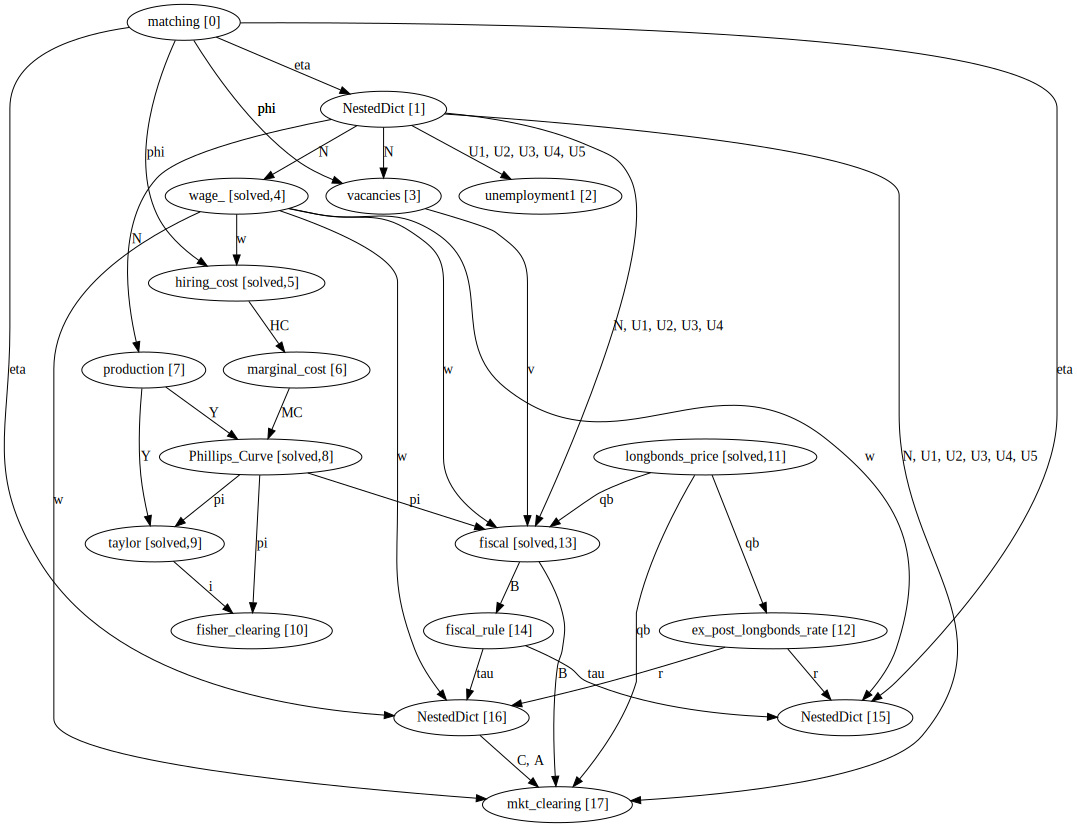

In [9]:
sj.drawdag(HANK_SAM)

# Impulse response analysis

In [10]:

# This function will helps plot irfs
def plot_irfs(irf_b1,irf_b2, label_b1 , label_b2 ):
    
    green = 'darkorange'
    benchmark =  label_b1
    fixed_rate = label_b2
    Length = 40
    fontsize = 10
    width = 2
    label_size = 8
    legend_size = 8
    ticksize = 8
    fig, axs = plt.subplots(3, 2, figsize=(7,8))
    axs[0, 0].plot(10000*irf_b1['i'][:Length],linewidth= width,label = benchmark )
    axs[0, 0].plot(10000*irf_b2['i'][:Length],linewidth= width, label = fixed_rate , linestyle = '--', color = green)
    axs[0, 0].plot(np.zeros(Length),'k' )
    axs[0, 0].legend(prop={'size': legend_size})
    axs[0, 0].set_ylabel('Basis points (quarterly)', fontsize = label_size)
    axs[0, 0].set_xlabel('Quarters', fontsize = label_size)

    axs[0, 0].set_title("Nominal Interest Rate",fontdict={'fontsize': fontsize})
    axs[0, 0].tick_params(axis='both', labelsize=ticksize)
    axs[0, 0].locator_params(axis='both', nbins=5) 
    axs[1, 0].plot(100*irf_b1['Y'][:Length]/Y_ss,linewidth= width, label = benchmark )
    axs[1, 0].plot(100*irf_b2['Y'][:Length]/Y_ss,linewidth= width,label = fixed_rate, linestyle = '--' , color = green)
    axs[1, 0].plot(np.zeros(Length),'k' )
    axs[1, 0].set_ylabel('% Deviation', fontsize = label_size)
    axs[1, 0].set_title("Output",fontdict={'fontsize': fontsize})
    axs[1, 0].sharex(axs[0, 0])
    axs[1, 0].tick_params(axis='both', labelsize=ticksize)
    axs[1, 0].set_xlabel('Quarters', fontsize = label_size)
    axs[1, 0].locator_params(axis='both', nbins=5) 
    axs[0, 1].plot(100*irf_b1['U'][:Length],linewidth= width, label = benchmark)
    axs[0, 1].plot(100*irf_b2['U'][:Length],linewidth= width, label = fixed_rate, linestyle = '--', color = green)
    axs[0, 1].plot(np.zeros(Length),'k' )
    axs[0, 1].set_ylabel('% points', fontsize = label_size)
    axs[0, 1].set_xlabel('Quarters', fontsize = label_size)

    axs[0, 1].set_title("Unemployment Rate",fontdict={'fontsize': fontsize})
    axs[0, 1].tick_params(axis='both', labelsize=ticksize)
    axs[0, 1].locator_params(axis='both', nbins=4) 
    axs[1, 1].plot(100*irf_b1['pi'][:Length],linewidth= width, label = benchmark)
    axs[1, 1].plot(100*irf_b2['pi'][:Length],linewidth= width, label = fixed_rate, linestyle = '--', color = green)
    axs[1, 1].plot(np.zeros(Length),'k' )
    axs[1, 1].tick_params(axis='both', labelsize=ticksize)
    axs[1, 1].set_title("inflation",fontdict={'fontsize': fontsize})
    axs[1, 1].set_ylabel('% points', fontsize = label_size)
    axs[1, 1].set_xlabel('Quarters', fontsize = label_size)
    axs[1, 1].locator_params(axis='both', nbins=4) 
    axs[2, 1].plot(100*irf_b1['C'][:Length]/C_ss,linewidth= width, label = benchmark)
    axs[2, 1].plot(100*irf_b2['C'][:Length]/C_ss,linewidth= width, label = fixed_rate, linestyle = '--', color = green)
    axs[2, 1].plot(np.zeros(Length),'k' )
    axs[2, 1].tick_params(axis='both', labelsize=ticksize)
    axs[2, 1].set_title("Consumption",fontdict={'fontsize': fontsize})
    axs[2, 1].set_ylabel('% deviation', fontsize = label_size)
    axs[2, 1].set_xlabel('Quarters', fontsize = label_size)
    axs[2, 1].locator_params(axis='both', nbins=4) 
    axs[2, 0].plot(10000*irf_b1['r_ante'][:Length],linewidth= width, label = benchmark)
    axs[2, 0].plot(10000*irf_b2['r_ante'][:Length],linewidth= width, label = fixed_rate, linestyle = '--', color = green)
    axs[2, 0].plot(np.zeros(Length),'k' )
    axs[2, 0].tick_params(axis='both', labelsize=ticksize)
    axs[2, 0].set_title("real interest rate",fontdict={'fontsize': fontsize})
    axs[2, 0].set_ylabel('basis points (quarterly)', fontsize = label_size)
    axs[2, 0].set_xlabel('Quarters', fontsize = label_size)
    axs[2, 0].locator_params(axis='both', nbins=4) 
    fig.tight_layout()


# Negative demand shock (positive discount factor shock)

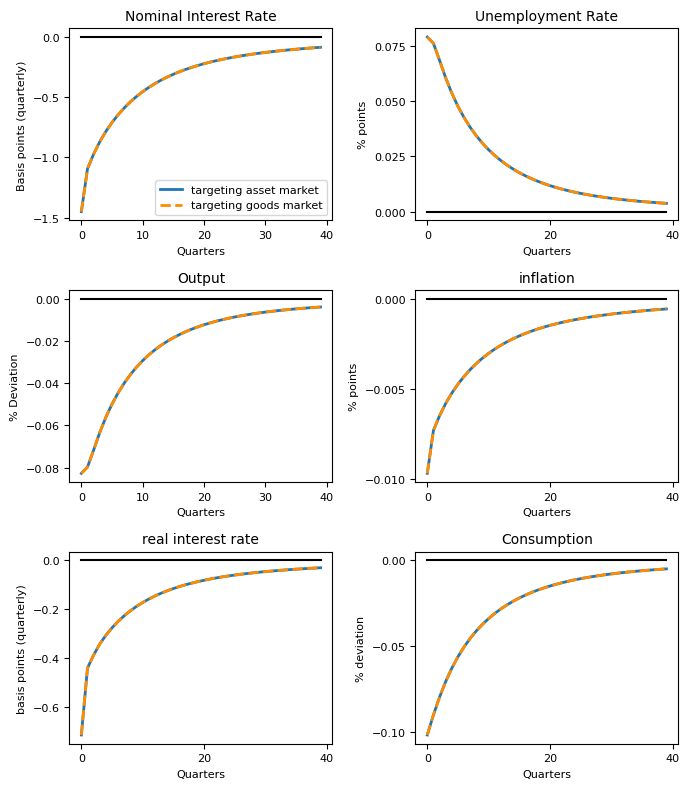

In [11]:

unknowns = ['theta', 'r_ante' ]
targets = ['asset_mkt', 'fisher_resid' ]
targets_goods_mkt = ['asset_mkt', 'fisher_resid' ]

T = bigT

rho_df  = 0.9 # quarterly persistence of discount factor shock
ddf = (.98*.001/2.1) * rho_df ** np.arange(T) # discount factor shock
shocks_df = {'DiscFac': ddf}


SteadyState_Dict_df = deepcopy(SteadyState_Dict)

SteadyState_Dict_df['phi_b'] = 0.1  # fiscal adjustment parameter
SteadyState_Dict_df['phi_w'] = 1.0 # wage ridigity parameter ( if equal to 1.0 than real wage is fixed)
SteadyState_Dict_df['rho_r'] = 0.0 # inertial parameter for taylor rule
SteadyState_Dict_df['phi_y'] = 0.0 # taylor rule coefficient on output
SteadyState_Dict_df['phi_pi'] = 1.5 # taylor rule coefficient on inflation

irfs_df = HANK_SAM.solve_impulse_linear(SteadyState_Dict_df, unknowns, targets, shocks_df) # solve for IRFs
irfs_df_goods_mkt = HANK_SAM.solve_impulse_linear(SteadyState_Dict_df, unknowns, targets_goods_mkt, shocks_df)  # solve for IRFs



green = 'green'

irf_asset_mkt = irfs_df
irf_goods_mkt = irfs_df_goods_mkt

benchmark =  'targeting asset market'
label_goods_mkt =  'targeting goods market'


plot_irfs(irf_asset_mkt,irf_goods_mkt  , benchmark , label_goods_mkt)




# Check goods market clears when targeting asset market clearing

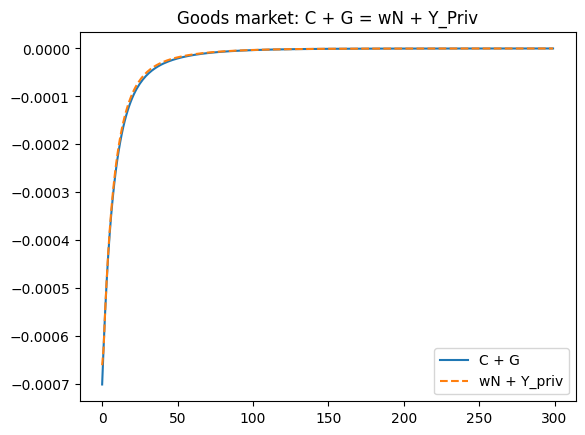

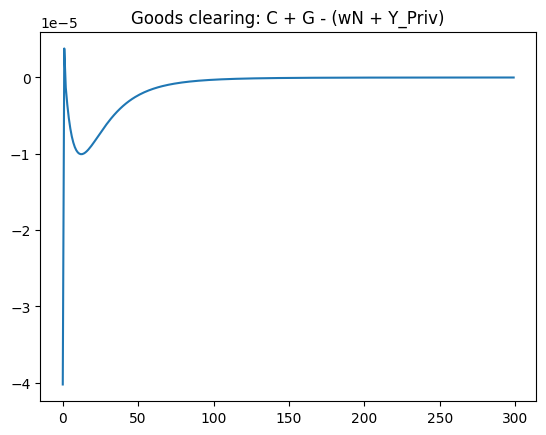

In [12]:


plt.plot(irf_asset_mkt['C'] , label = 'C + G')
plt.plot(wage_ss*irf_asset_mkt['N'] + irf_asset_mkt['w']*N_ss +irf_asset_mkt['Y_priv'] , linestyle ='--' ,label = 'wN + Y_priv') # this assume a fixed real wage
plt.legend()
plt.title('Goods market: C + G = wN + Y_Priv')
plt.show()

plt.plot(irf_asset_mkt['goods_mkt'])
plt.title('Goods clearing: C + G - (wN + Y_Priv)')
plt.show()


# Different stimulus policies

In [13]:
def NPV(irf,length): # to compute Net present value
    
    NPV = 0
    for i in range(length):
        
        NPV +=irf[i]/R**i
        
        
    return NPV

# UI extensions

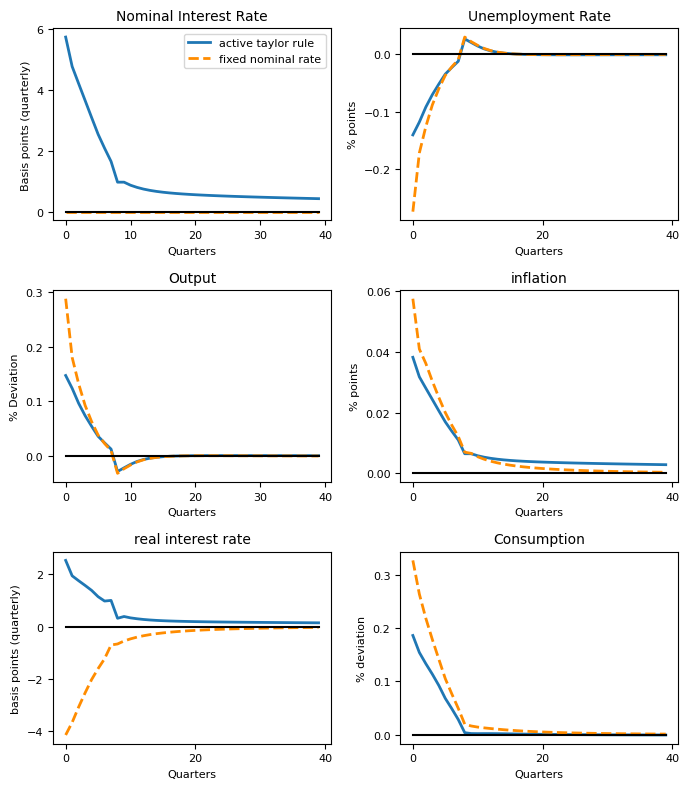

In [37]:



#rho_UI_extension  = 0.9
#dUI_extension = (.98*.001/2.1) * rho_UI_extension ** np.arange(T)

dUI_extension = np.zeros(bigT)
dUI_extension[:8] = .2
shocks_UI_extension = {'UI_extend': dUI_extension}


SteadyState_Dict_UI_extend = deepcopy(SteadyState_Dict)

SteadyState_Dict_UI_extend['phi_b'] = 0.015 #fiscal adjustment parameter
SteadyState_Dict_UI_extend['phi_w'] = 0.837 #wage ridigity parameter ( if equal to 1.0 than real wage is fixed)
SteadyState_Dict_UI_extend['rho_r'] = 0.0 #inertial parameter for taylor rule
SteadyState_Dict_UI_extend['phi_y'] = 0.0 #taylor rule coefficient on output
SteadyState_Dict_UI_extend['phi_pi'] = 1.5 #taylor rule coefficient on inflation
SteadyState_Dict_UI_extend['deficit_T'] = -1  #the number of periods it takes for government to adjust and follow its fiscal rule.
#If equal deficit_T = -40, then government will keep taxes fixed for 40 quarters



SteadyState_Dict_UI_extend_fixed_nominal_rate = deepcopy(SteadyState_Dict_UI_extend)
SteadyState_Dict_UI_extend_fixed_nominal_rate['phi_pi'] = 0.0 # taylor rule is not active

irfs_UI_extend = HANK_SAM.solve_impulse_linear(SteadyState_Dict_UI_extend, unknowns, targets, shocks_UI_extension)
irfs_UI_extend_fixed_nominal_rate = HANK_SAM.solve_impulse_linear(SteadyState_Dict_UI_extend_fixed_nominal_rate, unknowns, targets, shocks_UI_extension)


green = 'green'

plot_irfs(irfs_UI_extend,irfs_UI_extend_fixed_nominal_rate,'active taylor rule' , 'fixed nominal rate')


In [38]:
print('multiplier out of 2Q UI extension', NPV(irfs_UI_extend['Y'], bigT)/NPV(irfs_UI_extend['UI_extension_cost'],bigT))

print('multiplier out of 2Q UI extension (fixed rate)',NPV(irfs_UI_extend_fixed_nominal_rate['Y'], bigT)/NPV(irfs_UI_extend_fixed_nominal_rate['UI_extension_cost'],bigT))

multiplier out of 2Q UI extension 0.8992249659129621
multiplier out of 2Q UI extension (fixed rate) 1.2703176821324298


### Consumption response across education groups

In [18]:
def plot_C_by_educ(irf):

    
    plt.plot(irf['C_dropout'], label = 'dropout')
    plt.plot(irf['C_highschool'] , label = 'highschool')
    plt.plot(irf['C_college'], label = 'college')
    plt.plot(np.zeros(len(irf['C_college'])), color ='k')

    plt.legend()
    plt.title('Consumption response across education groups')
    plt.xlim(-1,40)
    plt.show()


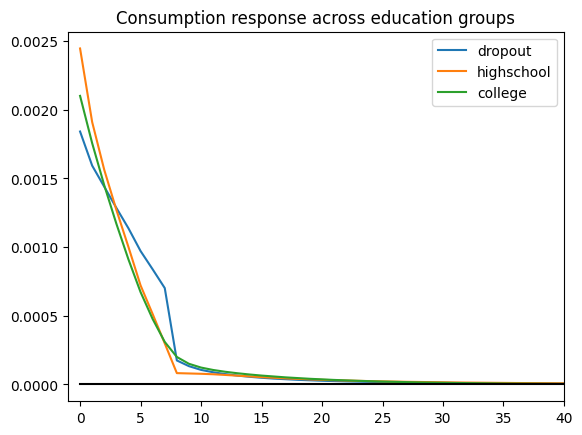

In [19]:
plot_C_by_educ(irfs_UI_extend_fixed_nominal_rate)

# Increasing the replacement rate of UI

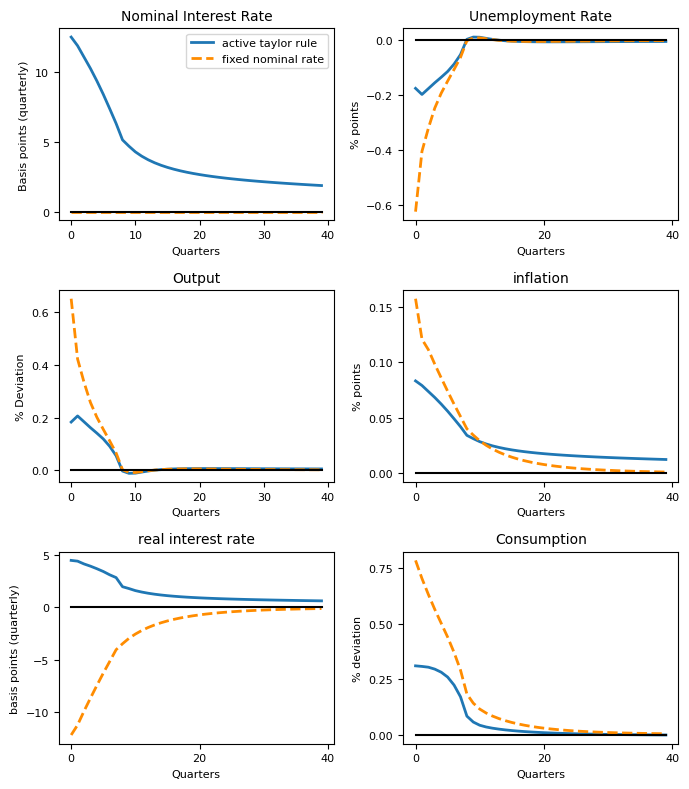

In [20]:


#rho_UI_extension  = 0.9
#dUI_extension = (.98*.001/2.1) * rho_UI_extension ** np.arange(T)

dUI_rr = np.zeros(bigT)
dUI_rr[:8] = .1
shocks_UI_rr = {'UI_rr': dUI_rr}


SteadyState_Dict_UI_rr = deepcopy(SteadyState_Dict)

SteadyState_Dict_UI_rr['phi_b'] = 0.015
SteadyState_Dict_UI_rr['phi_w'] = 0.837
SteadyState_Dict_UI_rr['rho_r'] = 0.0
SteadyState_Dict_UI_rr['phi_y'] = 0.0
SteadyState_Dict_UI_rr['phi_pi'] = 1.5
SteadyState_Dict_UI_rr['deficit_T'] = -1

SteadyState_Dict_UI_rr_fixed_nominal_rate = deepcopy(SteadyState_Dict_UI_rr)
SteadyState_Dict_UI_rr_fixed_nominal_rate['phi_pi'] = 0.0

irfs_UI_rr= HANK_SAM.solve_impulse_linear(SteadyState_Dict_UI_rr, unknowns, targets, shocks_UI_rr)
irfs_UI_rr_fixed_nominal_rate = HANK_SAM.solve_impulse_linear(SteadyState_Dict_UI_rr_fixed_nominal_rate, unknowns, targets, shocks_UI_rr)


green = 'green'

plot_irfs(irfs_UI_rr,irfs_UI_rr_fixed_nominal_rate,'active taylor rule' , 'fixed nominal rate')


### Consumption response across education groups

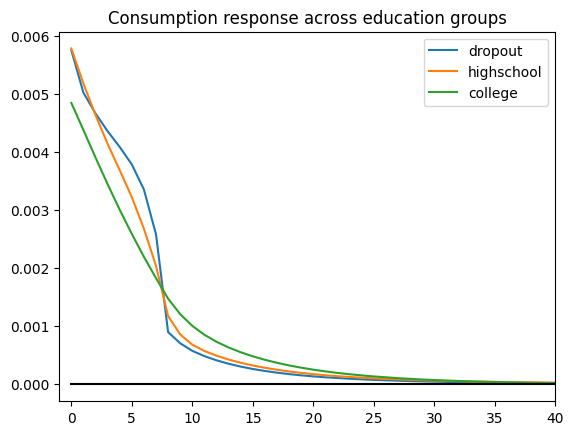

In [21]:
plot_C_by_educ(irfs_UI_rr_fixed_nominal_rate)

# Transfers


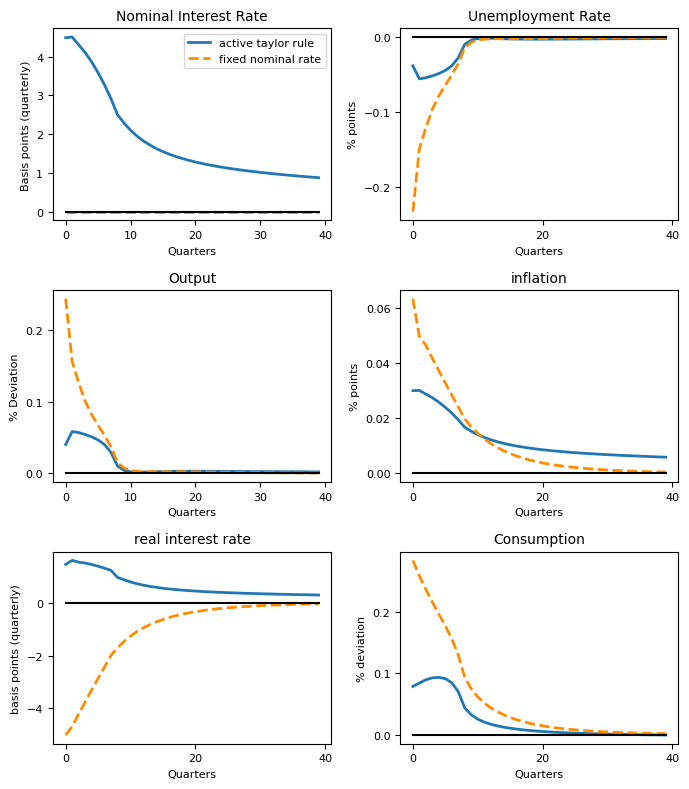

In [39]:



#rho_transfers  = 0.9
#dtransfers = (.98*.001/2.1) * rho_transfers ** np.arange(T)
#shocks_transfers = {'transfers': dtransfers}

policy_duration = 1 # number of quarters for which transfer takes place (1 is a stimulus check)
dtransfers = np.zeros(bigT)
dtransfers[:policy_duration] = Y_ss*.001
shocks_transfers = {'transfers': dtransfers}



SteadyState_Dict_transfer = deepcopy(SteadyState_Dict)

SteadyState_Dict_transfer['phi_b'] = 0.015  #lower bound from macro humps micro jumps paper
SteadyState_Dict_transfer['phi_w'] = 0.837
SteadyState_Dict_transfer['rho_r'] = 0.0
SteadyState_Dict_transfer['phi_y'] = 0.0
SteadyState_Dict_transfer['phi_pi'] = 1.5
SteadyState_Dict_transfer['deficit_T'] = -1

SteadyState_Dict_UI_transfer_fixed_nominal_rate = deepcopy(SteadyState_Dict_transfer)
SteadyState_Dict_UI_transfer_fixed_nominal_rate['phi_pi'] = 0.0

irfs_transfer = HANK_SAM.solve_impulse_linear(SteadyState_Dict_transfer, unknowns, targets, shocks_transfers)
irfs_transfer_fixed_nominal_rate = HANK_SAM.solve_impulse_linear(SteadyState_Dict_UI_transfer_fixed_nominal_rate, unknowns, targets, shocks_transfers)



plot_irfs(irfs_transfer,irfs_transfer_fixed_nominal_rate,'active taylor rule' , 'fixed nominal rate')


In [23]:
print('multiplier out of transfers', NPV(irfs_transfer['Y'], bigT)/NPV(irfs_transfer['transfers'],bigT))


print('multiplier out of transfers (fixed rate)', NPV(irfs_transfer_fixed_nominal_rate['Y'], bigT)/NPV(irfs_transfer_fixed_nominal_rate['transfers'],bigT))


multiplier out of transfers 0.6371742755184331
multiplier out of transfers (fixed rate) 1.1738621302962282


### Consumption response across education groups

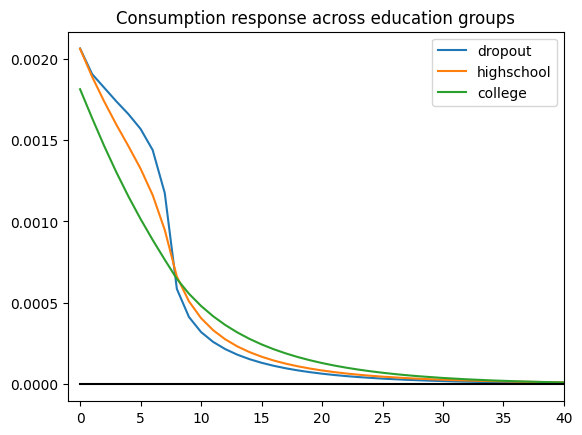

In [24]:
plot_C_by_educ(irfs_transfer_fixed_nominal_rate)

# Tax cut

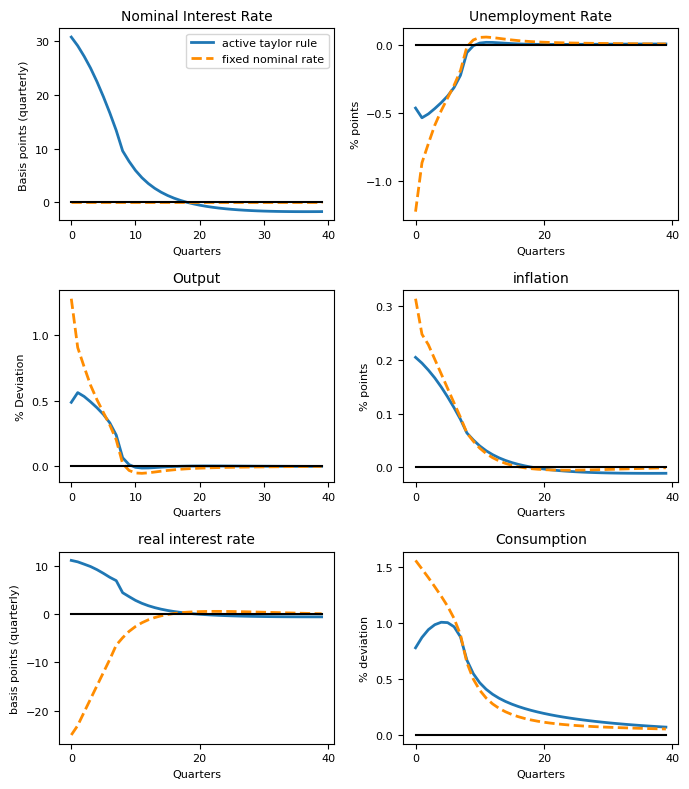

In [25]:


#rho_tau  = 0.9
#dtau = -(.05) * rho_tau ** np.arange(T)

policy_duration = 8
dtau = np.zeros(bigT)

dtau[:policy_duration] = -.01
shocks_tau = {'tau': dtau}


SteadyState_Dict_tax_shock = deepcopy(SteadyState_Dict)


SteadyState_Dict_tax_shock['phi_G'] = -0.05# fiscal adjustment parameter
SteadyState_Dict_tax_shock['phi_w'] = 0.837# wage ridigity parameter ( if equal to 1.0 than real wage is fixed)
SteadyState_Dict_tax_shock['rho_r'] = 0.0 #inertial parameter for taylor rule
SteadyState_Dict_tax_shock['phi_y'] = 0.0# taylor rule coefficient on output
SteadyState_Dict_tax_shock['phi_pi'] = 1.5# taylor rule coefficient on inflation
SteadyState_Dict_tax_shock['deficit_T'] = -1 # the number of periods it takes for government to adjust and follow its fiscal rule. 
#If equal to -40, then government will keep taxes fixed for 40 quarters

SteadyState_Dict_tax_shock_fixed_rate= deepcopy(SteadyState_Dict_tax_shock)
SteadyState_Dict_tax_shock_fixed_rate['phi_pi'] = 0.0

irfs_tau = HANK_SAM_tax_rate_shock.solve_impulse_linear(SteadyState_Dict_tax_shock, unknowns, targets, shocks_tau)
irfs_tau_fixed_rate = HANK_SAM_tax_rate_shock.solve_impulse_linear(SteadyState_Dict_tax_shock_fixed_rate, unknowns, targets, shocks_tau)




plot_irfs(irfs_tau,irfs_tau_fixed_rate ,'active taylor rule' , 'fixed nominal rate')


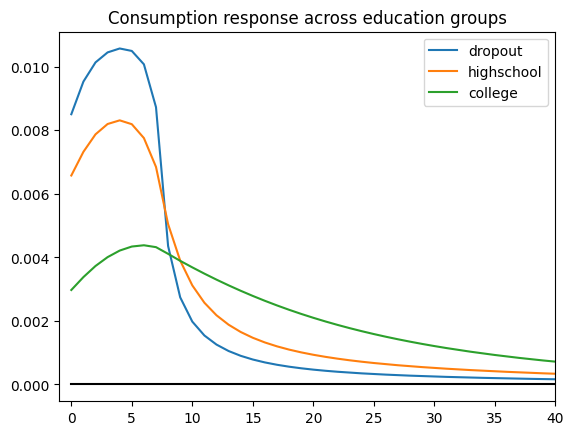

In [26]:
plot_C_by_educ(irfs_tau)

# Government Spending (e.g. defense spending)

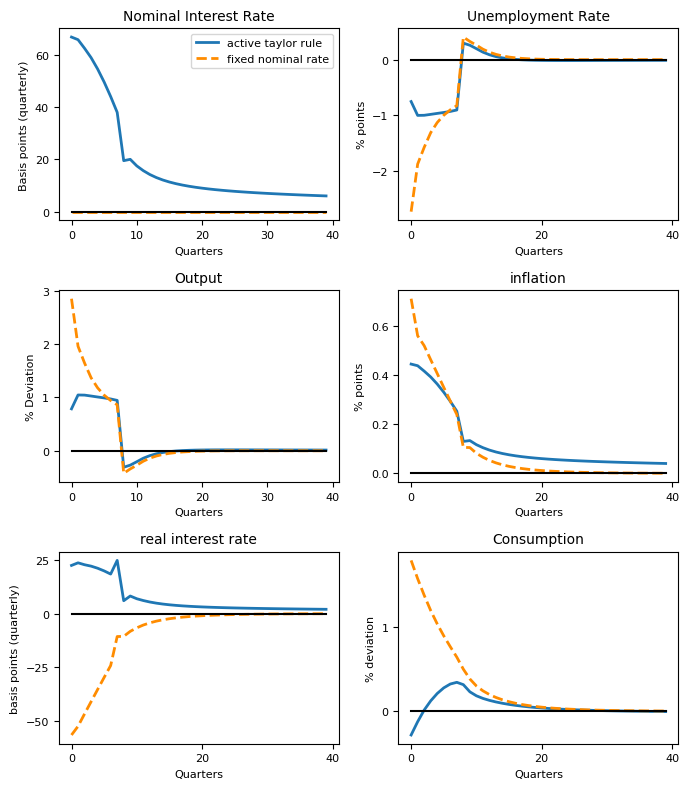

In [27]:

dG= np.zeros(bigT)
dG[:8] = Y_ss*.01
shocks_G = {'G': dG}



SteadyState_Dict_G = deepcopy(SteadyState_Dict)

SteadyState_Dict_G['phi_b'] = 0.015
SteadyState_Dict_G['phi_w'] = 0.837
SteadyState_Dict_G['rho_r'] = 0.0
SteadyState_Dict_G['phi_y'] = 0.0
SteadyState_Dict_G['phi_pi'] = 1.5
SteadyState_Dict_G['deficit_T'] = -1

SteadyState_Dict_G_fixed_nominal_rate = deepcopy(SteadyState_Dict_transfer)
SteadyState_Dict_G_fixed_nominal_rate['phi_pi'] = 0.0

irfs_G = HANK_SAM.solve_impulse_linear(SteadyState_Dict_G, unknowns, targets, shocks_G)
irfs_G_fixed_nominal_rate = HANK_SAM.solve_impulse_linear(SteadyState_Dict_G_fixed_nominal_rate, unknowns, targets, shocks_G)

plot_irfs(irfs_G,irfs_G_fixed_nominal_rate,'active taylor rule' , 'fixed nominal rate')


In [28]:
print('multiplier out of government spending', NPV(irfs_G['Y'], bigT)/NPV(irfs_G['G'],bigT))
print('multiplier out of government spending (fixed nominal rate)', NPV(irfs_G_fixed_nominal_rate['Y'], bigT)/NPV(irfs_G_fixed_nominal_rate['G'],bigT))


multiplier out of government spending 0.9303566801939241
multiplier out of government spending (fixed nominal rate) 1.298391555799382


# Sticky Expectations

In [29]:



def makesticky(theta,x): # see appendix D3 of micro jumps macro humps paper

    xsticky=x*0

    xsticky[:,0]=x[:,0]    
    xsticky[0,1:x.shape[1]]=(1-theta)*x[0,1:x.shape[1]]    

    for t in range(1,x.shape[0]):
        for s in range(1,x.shape[1]):

            xsticky[t,s]=theta*xsticky[t-1,s-1]+(1-theta)*x[t,s]

    return xsticky 


def stick_jacob(J,theta):

    Jsticky=deepcopy(J)

    for i in J.outputs:

        for j in J.inputs:
            
            x=J[i][j]
            
            xsticky=makesticky(theta,x)
            Jsticky[i][j]=xsticky

    return Jsticky


J_stick = stick_jacob(Jacobian_Dict, .925) # create sticky expectation jacobians with sticky parameter 0.925. This number implies that in each period following an MIT shock,only 1 - 0.925 of people update expectations.


HANK_SAM_sticky = create_model([J_stick, 
                          fiscal,
                          longbonds_price,
                          ex_post_longbonds_rate,
                          fiscal_rule,
                          
                          production,
                   
                          matching,
                          taylor,
                          Phillips_Curve,
                          marginal_cost,
                          UJAC_dict,
                    
                          hiring_cost,
                          wage_,
                          vacancies,
                          
                          unemployment1,

                          fisher_clearing,mkt_clearing], name="HARK_HANK")




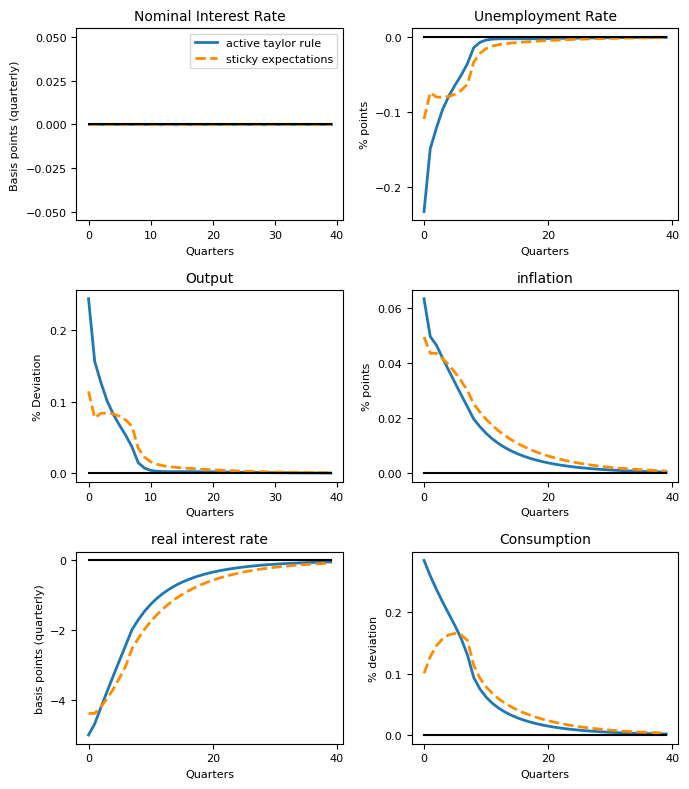

In [30]:
dtransfers = np.zeros(bigT)
dtransfers[:8] = Y_ss*.001
shocks_transfers = {'transfers': dtransfers}

SteadyState_Dict_transfer = deepcopy(SteadyState_Dict)

SteadyState_Dict_transfer['phi_b'] = 0.015
SteadyState_Dict_transfer['phi_w'] = .837
SteadyState_Dict_transfer['rho_r'] = 0.0
SteadyState_Dict_transfer['phi_y'] = 0.0
SteadyState_Dict_transfer['phi_pi'] = 0.0
SteadyState_Dict_transfer['deficit_T'] = -1


irfs_transfer_sticky_fixed_rate = HANK_SAM_sticky.solve_impulse_linear(SteadyState_Dict_transfer, unknowns, targets, shocks_transfers)


plot_irfs(irfs_transfer_fixed_nominal_rate,irfs_transfer_sticky_fixed_rate,'active taylor rule' , 'sticky expectations')


In [31]:
print('multiplier out of transfers(sticky expectations, fixed rate)', NPV(irfs_transfer_sticky_fixed_rate['Y'], bigT)/NPV(irfs_transfer_sticky_fixed_rate['transfers'],bigT))
print('multiplier out of transfers (fixed rate)', NPV(irfs_transfer_fixed_nominal_rate['Y'], bigT)/NPV(irfs_transfer_fixed_nominal_rate['transfers'],bigT))


multiplier out of transfers(sticky expectations, fixed rate) 1.0491969081341117
multiplier out of transfers (fixed rate) 1.1738621289970388


# Simulating the model

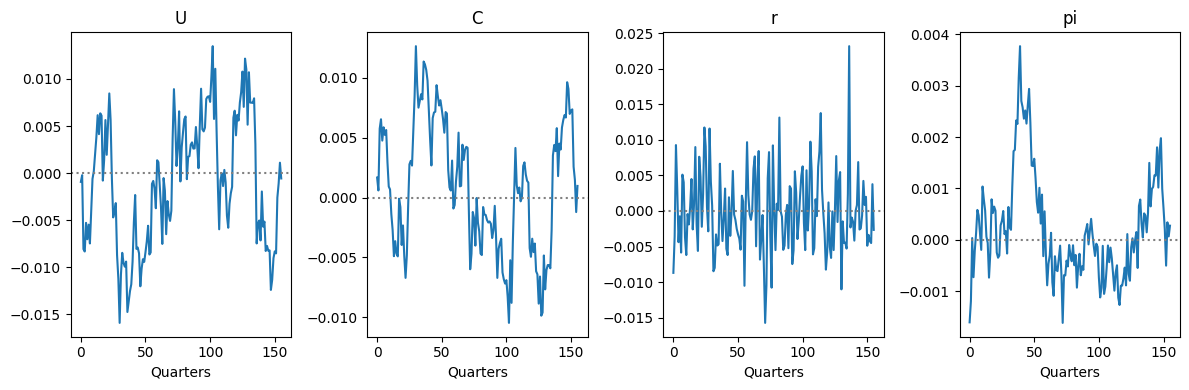

In [32]:

from estimation.plots import plot_timeseries
from estimation.routines import simulate


outputs = ["U", "C", "r", "pi"]

sigmas = {"ev": 0.001, "DiscFac": 0.001, "Z": 0.001}
rhos = {"ev": 0.9 , "DiscFac": 0.9, "Z": 0.9}
impulses = {}

inputs = ["ev" , "DiscFac" , "Z"]

for i in inputs:
    own_shock = {i: sigmas[i] * rhos[i] ** np.arange(T)}
    impulses[i] = HANK_SAM.solve_impulse_linear(
        SteadyState_Dict_df,
        unknowns,
        targets,
        own_shock,
    )


T_sim = 156  # 39 years, as in the original SW (2007) sample
data_simul = simulate(list(impulses.values()), outputs, T_sim)
plot_timeseries(data_simul, (1, 4), figsize=(12, 4))